In [1]:
## 1) Imports and Definitions:

In [2]:
%matplotlib inline
# import matplotlib
# import seaborn as sns
# matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
from matplotlib import pyplot as plt

In [3]:
plt.rcParams['figure.figsize']=[15,10]
# for some reason, this only saves if executed in a subsequent cell (vs. import or vs. %mpl inline ???)

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import bottleneck
import datetime
import time
import pickle
import os
import re
versionNumber = 4
logfile = 'logfile_%02d.txt' % versionNumber
regressionFitInputsCSV = 'rfi_%02d.csv' % versionNumber
verDIR = 'v%02d' % versionNumber
figDIR = verDIR+'/figs'
pickleDIR = verDIR+'/pickles'
if not(os.path.isdir(verDIR)):
    os.mkdir(verDIR)
    os.mkdir(figDIR)
    os.mkdir(figDIR+'/hubDist')
    os.mkdir(figDIR+'/Hubness_vs_R')
    os.mkdir(pickleDIR)

In [5]:
def makeTimeString():
    # produces a string yyyymmdd@HHMM of the current system clock time
    nowtime = datetime.datetime.now()
    return str(int(nowtime.year*1e4+nowtime.month*1e2+nowtime.day))+'@'+str(int(nowtime.hour*1e2+nowtime.minute))

In [6]:
makeTimeString()

'20190717@2244'

In [7]:
def getDistanceMatrix(L_v,ord=2):
    # input:    numpy array of vectors (N vectors, each of dim d: matrix is N*d)
                    # ord = which L-norm to use for pairwise distance computation. default 2
    # output:   N*N matrix of distances between each pair of vectors
            # only N*(N-1)/2 useful entries, due to symmetry. Output matrix diagonal is all zeros.
    n0 = len(L_v)
    distMatrix = np.zeros((n0,n0))
    for dex1 in range(n0-1):
        dist_to_i_d = L_v[(1+dex1):] - L_v[dex1]
        vectorNorms = np.linalg.norm(dist_to_i_d,ord=ord,axis=1)
        distMatrix[dex1,(1+dex1):] = vectorNorms
        distMatrix[(1+dex1):,dex1] = vectorNorms
    return distMatrix

In [8]:
bottleneck.__version__

'1.2.1'

In [9]:
def findNeighbors(L_v,k,ord_LNorm=2):
    # input:
        # L_v:         list of vectors in (N*d) matrix: N vectors, each with d dimensions
        # k:           number of nearest neighbors to find
        # ord_LNorm:   which order of L-norm to use for distance computation between each pair of vectors. Default=2
    # output:          N*(k+1) integer matrix. 
            # Each row i lists the indices of the (k+1) vectors that are nearest neighbors of vec L_v[i]
            # why (k+1)?
                # because each point always returns itself as its own single nearest neighbor 
                # since I will simply count total appearances for hubness, I can easily subtract one from each point later.
                # Will this cause any errors (e.g. if data were to contain identical points)?
                        # No, b/c it's prohibitively unlikely, especially for large d, float data, large k, etc.
    # This function is really easy to execute with bottleneck.argpartition
    N = len(L_v)
    distMatrix = getDistanceMatrix(L_v,ord_LNorm)
    k = min(k,N-1)
    neighbors = bottleneck.argpartition(distMatrix,k+1,axis=1)[:,:(k+1)]
            # Used argpartsort previously. That function no longer exists in bottleneck 1.2. Don't need to sort results anyway
    return [neighbors,distMatrix]

In [10]:
def findNeighbors_givenDists(distMatrix,k):
    # inputs:
        # N*N distance matrix
        # k: number of nearest neighbors to find
    # output: N*(k+1) integer matrix.  shows the k+1 nearest neighbors of each point (each row includes itself as a neighbor)
    N = len(distMatrix)
    k = min(k,N-1)
    neighbors = bottleneck.argpartition(distMatrix,k+1,axis=1)[:,:(k+1)]
    return neighbors

In [11]:
def plotHubnessDistribution(hist_hubness,d,k,n,filenameSuffix):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('Hubness Distribution: (d,k,n) = (%d, %d, %d)' % (d,k,n))
    ax.set_ylabel("Occurrence Frequency")
    #ax.set_ylim([0,1])
    if (d>29):
        ax.set_xlabel('N_k + 1')
        plt.plot(1+np.arange(len(hist_hubness)),hist_hubness/float(n),'o')
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_xlabel('N_k')
        plt.plot(hist_hubness/float(n))
    plt.savefig((figDIR+'/hubDist/hubnessDist_%s') % filenameSuffix)
    plt.close(fig)

In [13]:
def plot_Hubness_vs_R(hubness,R,d,k,n,filenameSuffix):
    # scatterplot: hubness vs. distance from origin
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('Hubness vs R: (d,k,n) = (%d, %d, %d)' % (d,k,n))
    ax.set_xlabel('R (distance from origin)')
    if (d>29):
        ax.set_ylabel("Log10(Hubness+1)")
        plt.plot(R,np.log10(hubness+1),'o')
    else:
        ax.set_ylabel("Hubness")
        plt.plot(R,hubness,'o')
    plt.savefig((figDIR+'/Hubness_vs_R/HvR_%s') % filenameSuffix)
    plt.close(fig)

In [22]:
print('%.0f' % 45.7)

46


In [ ]:
## 2) Data Generation, Nearest-Neighbor, and Hubness Computations

In [ ]:
# %time (neighbors,dists)=findNeighbors(X,k,ord_LNorm=2)
    # I think the distMatrix computation is the biggest factor here: should be O(n2 * d)
    # I see no execution time dependence on k
        # so argpartsort (which should go as n log k, assuming it's done with a heap?) is presumably much faster

In [ ]:
# Execute the following cell with a variety of values for d, k, and n

# d = dimensionality of space
# k = number of neighbors
# n = number of points

In [24]:
dList=[1,2,3,5,10,20,30,50,100,200,300,500,1000,2000,3000,5000]
k=10
n=1000
with open(logfile,"a") as fh:
    for d in dList:
        print('d = %d' % d)
        ticD = time.time()
        fh.write("d=%d\n" % d)
        fh.write("k=%d\n" % k)
        fh.write("n=%d\n" % n)
        for _ in range(25): # draw 25 independent sample datasets for each (d,k,n)
            fh.write("set %d\n" % _)
            tic=time.time()
            print('%02d %.1f' % (_,tic-ticD))
            mySeed = (int(tic*(10**6))) % (2**32)
            np.random.seed(mySeed)
                # ok this does limit numPossibleDatasets to 2**32 (cf. Mersenne Twister = 2**19937 - 1)
                    # but a collision is still extremely unlikely, and it really doesn't matter that much anyway
            fh.write("    seed = %d" % mySeed) # if we wish to reproduce any pointCloud later, can read a seed from log file
            X = np.random.normal(0,1,(n,d))
            #(neighbors,dists)=findNeighbors(X,k,ord_LNorm=2)  # this was the slow step, others all fast
            # For some reason it runs faster when computing distances separately
            # Okay, we'll replace that with separate explicit calls. (Why is this faster???) 
            # Also let's get both k and k+1 NN lists. Useful for determining the distance to the (k+1)th point
            dists = getDistanceMatrix(X,ord=2)                      # O(d * n**2)    This is the slow step! 
            neighbors = findNeighbors_givenDists(dists,k)           # O(n**2)
            neighbors_kp1 = findNeighbors_givenDists(dists,k+1)     # O(n**2)
            vecNeighbors = np.reshape(neighbors,n*(k+1))
            hubness = np.bincount(vecNeighbors)-1   # minus 1 removes self as nearest neighbor
            hist_hubness = np.bincount(hubness)
            #skewness = (sum((hubness-k)**3)/float(n))/((np.std(hubness))**3)  # mean(hubness) = k
            #print(skewness)
            skewHub = skew(hubness)
            fh.write("    skewness = %f\n" % skewHub) # skewness of the hubness
            R = np.linalg.norm(X,ord=2,axis=1)  # distance from origin to each point
            fnSuf1 = '_d%04d_k%03d_n%05d_#%02d' % (d,k,n,_)
            filenameSuffix = '_d%04d_k%03d_n%05d_#%02d_%s.png' % (d,k,n,_,makeTimeString())
            plotHubnessDistribution(hist_hubness,d,k,n,filenameSuffix)
            plot_Hubness_vs_R(hubness,R,d,k,n,filenameSuffix)
            pickle.dump(hubness,open((pickleDIR+'/hubness%s.p') % fnSuf1,'wb'))
            pickle.dump(R,open((pickleDIR+'/R%s.p') % fnSuf1,'wb'))
            pickle.dump(neighbors,open((pickleDIR+'/neighbors%d_%s.p') % (k,fnSuf1),'wb'))
            pickle.dump(neighbors_kp1,open((pickleDIR+'/neighbors%d_%s.p') % (k+1,fnSuf1),'wb'))
            toc=time.time()
            fh.write("    Execution Time: %.2f s\n" % (toc-tic))
        fh.write("\n\n\n")
        print('Loop execution time: %.3f sec' % (time.time()-ticD))

d = 200000
00 0.0
01 1050.3
02 2097.9
03 3147.0
04 4194.4
05 5243.7
06 6289.7
07 7339.7
08 8388.7
09 9436.6
10 10487.5
11 11534.9
12 12583.8
13 13633.8
14 14681.8
15 15732.3
16 16781.8
17 17832.9
18 18881.2
19 19928.8
20 20975.9
21 22027.6
22 23071.5
23 24120.1
24 25168.5
Loop execution time: 26222.909 sec


In [ ]:
## 3) Read Data from all Pickles, write to CSV: 

In [14]:
pattern = re.compile('^hubness_d(\d+)_k010_n(\d+)_#(\d+)\.p$')  # combos (d,n,#) where k=10
numHubnesses2Pull = 10  # find fraction of data set that has each hubness value less than this number
with open(regressionFitInputsCSV,"w") as fh:
    fracHeaders = ','.join(['f'+str(x) for x in range(numHubnesses2Pull)])
    fh.write("d,n,itno,%s\n" % fracHeaders)
    for file in os.listdir('v3/pickles'):
        key = pattern.findall(file)
        if key:
            (d,n,itno) = [int(x) for x in key[0]]
            with open('v3/pickles/'+file,'rb') as myfile:
                hubness=pickle.load(myfile)
            #hubness = pickle.load(open('v2/pickles/'+file,'rb'))
            fracs = [np.count_nonzero(hubness==Nk)/float(n) for Nk in range(numHubnesses2Pull)]
            stringFracs = ','.join([str(ff) for ff in fracs])
            fh.write("%d,%d,%d,%s\n" % (d,n,itno,stringFracs))

In [ ]:
## 4) Fit Lasso Linear Regression Model, to predict d from n


In [21]:
data = pd.read_csv('rfi.csv')
predictors = pd.DataFrame(np.log10(data['n'])).rename(columns={"n": "logN"})
for jj in range(2):
    predictors['f'+str(jj)] = data['f'+str(jj)]  # we will only use the first two hubnesses
        # i.e. (what fraction of points are no-one else's nearest neighbor, what frac of pts are only NN for one other pt)

        
#for jj in range(10):
#    predictors['fs'+str(jj)] = (predictors['f'+str(jj)])**2
#predictors['logN'] = np.log10(data['n'])
# predictors['logN_sq'] = (np.log10(data['n']))**2



In [29]:
Y = np.log10(data['d'])  # we will try to predict the dimension 'd'
                                    # predictors: logN and the two hubness fractions f0 and f1

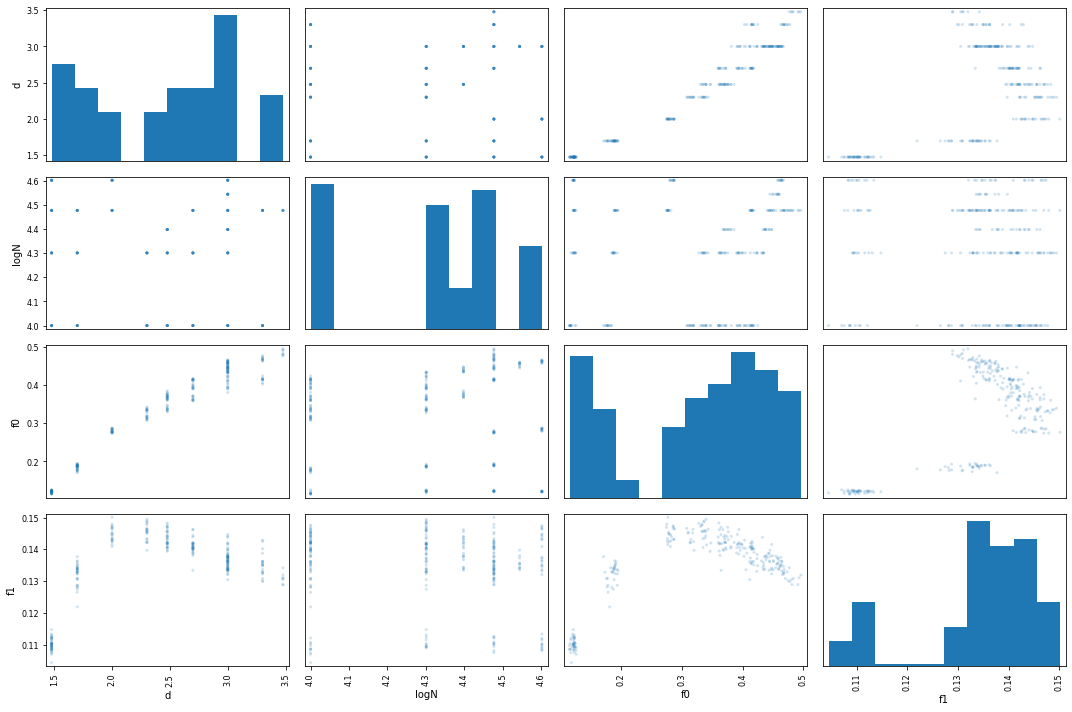

In [44]:
# Pairwise feature scatterplot (cf. R's "pairs" function)
# Very useful way to visualize relationships between variables!
axes = pd.plotting.scatter_matrix(pd.concat([Y,predictors],axis=1), alpha=0.2)
plt.tight_layout()

In [46]:
model.coef_

array([-0.37177363,  5.67842116, -9.42813388])

In [ ]:
# f0:
    # f0 is obviously going to be the most important predictor.
    # The variables log d and f0 have strong positive correlation, as expected.
        # high d: hubness is concentrated in a very small number of hubs. Lots of other points are left with zero hubness.
        
# f1:
    # d has an interesting relationship with f1
        # but f1 might not be an especially useful predictor
            # the d-vs-f1 relationship is likely captured by the d-vs-f0 and f1-vs-f0 relationships
    # Phenomenology here:
        # For small d, f0 and f1 are both fairly small.
            # No concentration into big hubs: therefore, the number of points with zero or one hubness is also small
            # Interesting that even for d=30 (the smallest choice used for regression fit in Dec'17): f0 still exceeds f1
                # I expect that will change as d drops even further
                    # Consider the d=1 case: a univariate normal distribution.
                        # There could only be 1-2 extreme outliers so far from the distribution as to have zero hubness
                        # Here I think f10 would be a peak 
        # For huge d, f1 decreases again, b/c f0 is capturing a higher and higher fraction of the overall points
            # I presume that f1 would still be increasing relative to (1-f0) ???
            
# log N:
    # in theory, this shouldn't be related to d at all
        # first of all, they were both initially chosen for our simulations! so any relationship here is meaningless
            # recall that f0 and f1 are the results of the calculations
                # although we will be treating them as the independent variables for regression model
        # the research idea is eventually to measure f0/f1/etc. to predict the "effective dimension" of a real dataset

In [24]:
model = LassoCV(cv=len(predictors),eps=1e-3,max_iter=1000)  # LOO CV
model.fit(predictors,Y)
Y_obs = Y
Y_pred = pd.Series(model.predict(predictors))

In [25]:
model

LassoCV(alphas=None, copy_X=True, cv=257, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [33]:
model.coef_

array([-0.37177363,  5.67842116, -9.42813388])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Lasso Linear Regression Fit')
ax.set_ylabel("Observed Dimension")
ax.set_xlabel("Predicted Dimension")
plt.plot(Y_pred,Y_obs,'ko',markersize=4)
plt.plot(Y_pred[predictors['logN']==np.log10(10000)],Y_obs[predictors['logN']==np.log10(10000)],'ro',markersize=4)
plt.plot([1,3.5],[1,3.5],'k')

In [ ]:
metrics.r2_score(Y_obs,Y_pred)

In [ ]:
print(model.predict(np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])))
print(model.predict(np.array([[1,0,0],[0,1,0],[0,0,1]]))-model.predict(np.array([[0,0,0]])))

In [ ]:
pickle.dump(model,open('lassoRegressionModel.p','wb'))

In [ ]:
## 4b) Skewness vs d

In [ ]:
ds = pd.read_csv('rfiSkew.csv')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ds['d'],ds['skewness'],'ko')
#plt.plot(ds.ix[ds['n']==10000,'d'],ds.ix[ds['n']==10000,'skewness'],'ro')
#plt.plot(ds.ix[ds['n']==30000,'d'],ds.ix[ds['n']==30000,'skewness'],'go')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Skewness of Hubness: Normal Distribution')
ax.set_xlabel('d')
ax.set_ylabel('skewness of N_10')
fig.savefig('SOH_vs_d')

In [ ]:
# 4c) Deep Dive: Investigate run 8 from d=500,n=30000, since it had such high skewness (75):

In [ ]:
d=500
k=10
n=30000
runNumber = 8
r8_string = ('_d' + '%04d' + '_k' + '%03d' + '_n' + '%05d' + '_#' + '%d') % (d,k,n,runNumber)
hubness = pickle.load(open('v2/pickles/hubness' + r8_string + '.p','r'))
neighbors10 = pickle.load(open('v2/pickles/neighbors10_' + r8_string + '.p','r'))
neighbors11 = pickle.load(open('v2/pickles/neighbors11_' + r8_string + '.p','r'))
R = pickle.load(open('v2/pickles/R' + r8_string + '.p','r'))
inlier = np.where(hubness==max(hubness))[0]

In [ ]:
R2_inlier = R[inlier]**2

In [ ]:
from scipy.stats import chi2
dof=d
p1 = chi2.cdf(R2_inlier,df=500)
total_points_generated_at_d_eq_500 = 6e5
total_points_entire_data_set = 5960000
pn = 1 - (1-p1)**n
pTot = 1 - (1-p1)**total_points_generated_at_d_eq_500
pEntire = 1 - (1-p1)**total_points_entire_data_set
print(p1)
print(pn)
print(pTot)
print(pEntire)

In [ ]:
1./n * ((hubness[inlier]-k)**3)/(hubness.std()**3)
# This is the amount contributed to the skewness by the one term.
# It would be misleading to subtract it and imply that the skewness of the rest of the set is just 3.5
    # because removing one hub changes all the other NN lists, etc.
        # still however, it does illustrate how much a single inlier can dominate the skewness result

In [ ]:
# But having saved the 10-nearest-neighbor and 11-nearest-neighbor lists,
    # I can in fact generate a new array of hubnesses N_10, assuming that the extreme inlier is removed!

neighbors = np.int64(np.zeros([n,k+1]))
for jj in range(n):
    if (inlier in neighbors10[jj]):
        neighbors[jj,:] = np.delete(neighbors11[jj], np.where(neighbors11[jj] == inlier), axis=0)
    else:
        neighbors[jj,:] = neighbors10[jj]
neighbors[inlier] = neighbors[-1] # overwrite row corresponding to original inlier
neighbors = neighbors[:-1] # remove last row (which is now a duplicate)
np.place(neighbors,neighbors==len(neighbors),inlier) # re-indexes the old endpoint to the inlier's index
vecNeighbors = np.reshape(neighbors,(n-1)*(k+1))
newHubness = np.bincount(vecNeighbors)-1
print(skew(newHubness))

In [ ]:
## 5) Linear Regression on logN, f0, and f1

# Actually Lasso uses just three parameters: logN, f0, and f1.
        # So as an alternative, we could also try a standard linear regression on just these three parameters

In [ ]:
data = pd.read_csv('rfi.csv')
predictors = pd.DataFrame(np.log10(data['n'])).rename(columns={"n": "logN"})
for jj in range(2):
    predictors['f'+str(jj)] = (data.ix[:,['f'+str(jj)]])
#for jj in range(10):
#    predictors['fs'+str(jj)] = (predictors['f'+str(jj)])**2
#predictors['logN'] = np.log10(data['n'])
# predictors['logN_sq'] = (np.log10(data['n']))**2
Y = np.log10(data['d'])


In [ ]:
predictors.head()

In [ ]:
linreg_model = LinearRegression()
linreg_model.fit(predictors,Y)
Y_obs = Y
Y_pred = pd.Series(linreg_model.predict(predictors))

In [ ]:
linreg_model